# Fig S1: Showing properties of null model where growth is decoupled from cell-size

## Setup

In [132]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
using Setfield
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load simulated data used in Fig4

In [133]:
# get sims
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original;

In [134]:
# -----------------------------------------------------------
# build model and run 
θ = GrowthTraceTools.θOU
θ = @set θ.σDN = 0.0
θ = @set θ.D = 0.0
θ = @set θ.σDN = GrowthTraceTools.σGR .* 10 /θ.τ
prob,callback,names = GrowthTraceTools.build_model_OU(θ,GrowthTraceTools.initOU,collect(0:0.05:10*max(sims.time...)))
sol = solve(prob,callback = callback);


# -----------------------------------------------------------
# put in dataframe 
d = GrowthTraceTools.solver_output_to_dataframe(sol,names);

## Show near independent of cell-cycle and growth rates

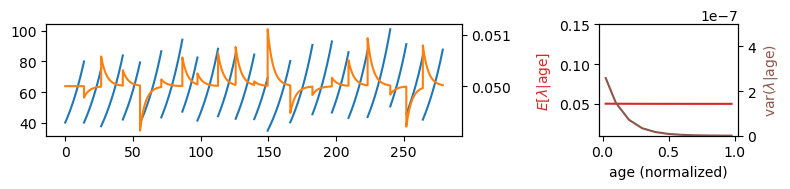

In [144]:
#d = sims[sims.lineage_original .==22,:]
d = d[d.position .< 20,:]
da = combine(groupby(d,:age_rounded),:λ => var => :var_gr,:λ => mean => :mean_gr,:age_normed => mean => :age)

fig, axs = subplots(1, 2, gridspec_kw = Dict("width_ratios" => [3, 1]),figsize=(8,2))

ax = axs[0]
#d1 = d[d.replicate .==1,:]
d1 = d
[ax.plot(d1[d1.position .==p,:].time,d1[d1.position .==p,:].M,"C0") for p in unique(d1.position)]
ax2 = ax.twinx()
ax2.plot(d1.time,d1.λ,"C1")

# Create the second subplot
ax = axs[1]
ax.plot(da.age,da.mean_gr,"C3-")
ax.set_ylim([0.01,2*0.075])
ax.set_xlabel("age (normalized)")
ax.set_ylabel(L"$E[\lambda|{\rm age}]$",color="C3")

ax2 = ax.twinx()
ax2.plot(da.age,da.var_gr,"C5-")
ax2.set_ylabel(L"${\rm var}(\lambda|{\rm age})$",color="C5")

ax2.set_ylim([0,5e-7])


tight_layout()
fig
